# TitaNet

This repository contains a small scale implementation of the following paper:

```
TitaNet: Neural Model for speaker representation with 1D Depth-wise separable convolutions and global context,
Nithin Rao Koluguri, Taejin Park, Boris Ginsburg,
https://arxiv.org/abs/2110.04410.
```

It is "small scale" because we only rely on the LibriSpeech dataset, instead of using VoxCeleb1, VoxCeleb2, SRE, Fisher, Switchboard and LibriSpeech, as done in the original work. The main reason for this choice is related to resources, as the combined dataset has $3373$ hours of speech, with $16681$ speakers and $4890K$ utterances, which is quite big to be trained on Google Colab. Instead, the LibriSpeech subset that we consider has about $100$ hours of speech, with $251$ speakers and $28.5K$ utterances, which is sufficient to test the capabilities of the model. Moreover, we only test TitaNet on the speaker identification and verification tasks, instead of also testing it on speaker diarization.

## Colab

Make sure to select the GPU runtime before executing any of the cells down below.

In [ ]:
!nvidia-smi

Then, we'll be cloning the `titanet` Github repository.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!git clone https:/github.com/Wadaboa/titanet.git

Next, we'll also copy the W&B API key file from Google Drive (`Colab/wandb_api_key_file`) to Colab.

In [41]:
!cp /content/drive/MyDrive/Colab/wandb_api_key_file /content/titanet/init/wandb_api_key_file

cp: /content/drive/MyDrive/Colab/wandb_api_key_file: No such file or directory


Now we can install all the required libraries. Beware that after this step you'll probably be required to restart your Colab environment. If it happens, you can continue executing cells after the one down below.

In [ ]:
!pip install -r titanet/init/colab_requirements.txt

After restarting the environment, we need to change directories to the `titanet` folder.

In [ ]:
import os, sys

sys.path.insert(0, "titanet")
os.chdir("titanet")

And we're done hacking Colab. 

## Pre-requisites

This section takes care of importing the required libraries in the notebook environment.

In [1]:
import sys

sys.path.append("src/")

In [2]:
import os
import random

import yaml
import torch
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt

import datasets, utils, train, models, losses, transforms, learn

%load_ext autoreload
%autoreload 2

In [108]:
plt.style.use('default')

## Dataset

This section deals with dataset inspection. In particular, the only dataset we rely on is the [LibriSpeech](https://www.openslr.org/12) one and we import it directly from `torchaudio`.

In [97]:
dataset = datasets.LibriSpeechDataset("./data")

In order to test dataset indexing, we are going to sample a random example from it and call the `__getitem__` method. Indexing should return a dictionary with the following schema:

```json
{
    "waveform": ...,
    "sample_rate": ...,
    "spectrogram": ...,
    "speaker": ...,
    "speaker_id": ...
}
```

Here, `waveform` is a PyTorch tensor of shape $[1, A]$ where $A$ is the number of amplitude samples describing the audio snippet associated with the chosen random index, `sample_rate` is an integer identifying the number of samples for 1 second of audio, `spectrogram` is the mel-scaled spectrogram (initially empty) obtained from the raw waveform, `speaker` is the integer identifying a speaker in the original dataset and `speaker_id` is its mapping in the range $[0, S - 1]$, where $S$ is the total number of speakers.   

In [98]:
random_index = random.randint(0, len(dataset))
random_example = dataset[random_index]
random_example

{'waveform': tensor([[-0.0005, -0.0005, -0.0005,  ...,  0.0010,  0.0012,  0.0011]]),
 'sample_rate': 16000,
 'spectrogram': None,
 'speaker': 5703,
 'speaker_id': 159}

Now we can leverage Jupyter features to play the audio snippet directly inside this notebook.

In [99]:
utils.play_audio(random_example["waveform"], random_example["sample_rate"])

Finally, we can observe how many samples we have in the dataset and see if they are balanced for every speaker or not.

**Note**: durations are reported in hours, not seconds.

In [100]:
dataset.info()

Computing durations: 100%|█| 28539/28539 [00:16<00:00, 17


{'num_utterances': 28539,
 'num_speakers': 251,
 'total_duration': 100.59,
 'utterances_per_speaker_mean': 113.7,
 'utterances_per_speaker_std': 15.18,
 'durations_per_speaker_mean': 0.4,
 'durations_per_speaker_std': 0.04}

## Transforms

This section deals with understanding each speech transformation described in the TitaNet paper, that's applied to the input data. 

We'll start off with speed perturbation, which affects the speed at which speakers utter audio. In the paper authors use a minimum factor of $0.95X$ and a maximum factor of $1.05X$, so as not to alter audio properties too much. In order to test the effect of the transformation, we are going to use broader factors, between $0.5X$ and $1.5X$.

In [101]:
speed_transform = transforms.SpeedPerturbation(0.5, 1.5)
speed_example = speed_transform(random_example)
utils.play_audio(speed_example["waveform"], speed_example["sample_rate"])

The second transform is related to the extraction of a random chunk of audio whenever the input snippet exceeds a certain length (in seconds). In the paper, they extract random chunks of $1.5, 2$ or $3$ seconds for waveforms longer than $3$ seconds. In this example we'll always extract chunks of $2$ seconds.

In [102]:
chunk_transform = transforms.RandomChunk(3, [2])
chunk_example = chunk_transform(random_example)
utils.play_audio(chunk_example["waveform"], chunk_example["sample_rate"])

The third transform is related to reverberation, a phenomenon defined as "a persistence of sound after the sound is produced" by [Wikipedia](https://en.wikipedia.org/wiki/Reverberation). TitaNet authors rely on convolution reverb, which is a technique that applies a RIR (Room Impulse Response) filter on top of the clean signal, to act as if the original signal was uttered in a different environment. To do this, authors rely on the [Room Impulse Response and Noise Database](https://www.openslr.org/resources/28/rirs_noises.zip). 

**Note**: our convolution reverb implementation is taken from torchaudio's [audio preprocessing tutorial](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html).

In [103]:
reverb_transform = transforms.Reverb('./data/rirs')
reverb_example = reverb_transform(random_example)
utils.play_audio(reverb_example["waveform"], reverb_example["sample_rate"])

The fourth transform is a mandatory one, as it's tasked to convert the raw waveform to a mel-spectrogram. Our implementation relies on torchaudio to compute the mel-spectrogram, then transforms amplitudes to decibels and normalizes over the frequency dimension (as described in TitaNet paper). 

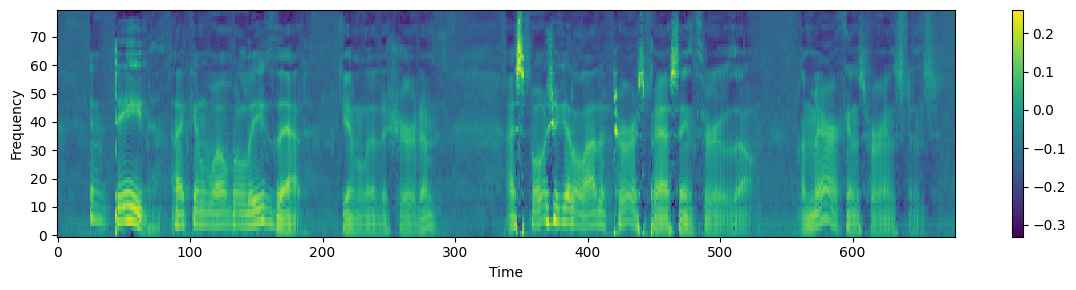

In [109]:
mel_spec_transform = transforms.MelSpectrogram(
    random_example["sample_rate"], n_mels=80, specaugment_probability=0.0
)
mel_spec_example = mel_spec_transform(random_example)
utils.plot_spectrogram(mel_spec_example["spectrogram"])

Finally, the fifth and final transform, `SpecAugment`, is a technique very similar to [Cutout](https://paperswithcode.com/method/cutout) in the vision domain, s.t. random consecutive patches of the spectrogram are masked with a constant value. As described in the [original paper](https://arxiv.org/abs/1904.08779), different patches may be applied to the time and frequency axes and multiple patches per axis may also be applied.

**Note**: due to implementation details, our custom `MelSpectrogram` transform includes the `SpecAugment` technique, which can be enabled/disabled and configured through specific parameters.

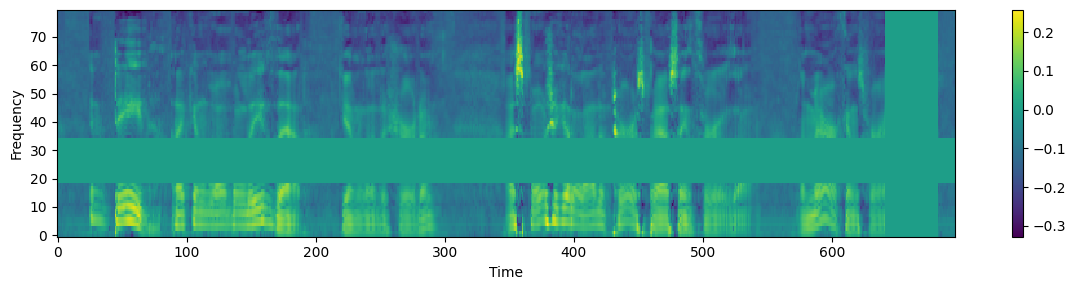

In [111]:
spec_augment_transform = transforms.MelSpectrogram(
    random_example["sample_rate"], n_mels=80, specaugment_probability=1.0
)
spec_augment_example = spec_augment_transform(random_example)
utils.plot_spectrogram(spec_augment_example["spectrogram"])

Since `SpecAugment` includes a time stretch before time and frequency masking, the speed perturbation transform is not needed anymore, as it would simply be a duplicate: the only difference is that speed perturbation is applied on the raw waveform, while time stretching is applied on the computed spectrogram.

## Baseline

This section explains the baseline model at a high-level (refer to the `models.py` module for further details).

### Model description

<img src="assets/models/d-vector.png" alt="d-vector" style="width: 450px;"/>
    
Our baseline model is based on the d-vector concept. A d-vector is simply a way to refer to speaker embeddings generated by a DNN (Deep Neural Network), hence the "d" prefix. The standard way to compute such d-vectors, as described in [Generalized End-to-End Loss for Speaker Verification](https://arxiv.org/abs/1710.10467), is through a stack of LSTM layers processing spectrogram segments. In particular, the full spectrogram of shape $B\times M\times T$ is unfolded in a sequence of tensors of shape $B\times M \times S$, where $S$ is the segment length. Then, each segment is fed into a recurrent module and hidden states are collapsed in a single dimension by either averaging or simply taking the last one. Collapsed vectors are then projected onto the embedding size and once we have one embedding vector for each segment, the embedding vector of the full spectrogram is just the average of all its constituent segments' embeddings.

## TitaNet

This section explains the TitaNet model at a high-level (refer to the `models.py` module for further details).

### Model description

<img src="assets/models/titanet-architecture.png" alt="titanet-architecture" style="width: 450px;"/>

TitaNet is an encoder-decoder architecture, where the encoder is quite complex, while the decoder is pretty simple. The encoder is divided into blocks $B_0,\dots,B_N$, where $B_0$ is called prolog and $B_N$ is called epilog. The prolog and epilog blocks are a sequence of 1D convolution, batch normalization and ReLU activation, while mega blocks are composed by $R$ sub blocks each ($R=3$ in the TitaNet paper).

One sub-block is a sequence of 1D depth-wise convolution, batch normalization, ReLU and dropout (beware that the dropout rate is not specified in the paper). After an input passes through all sub-blocks, it also goes through a squeeze and excitation layer. Then, the initial mega-block input is merged with the SE output through a skip connection that contains a $1x1$ convolution (to match input and output channels) and batch normalization. After the skip connection, ReLU activation and dropout are applied and one mega block computation is over.

The decoder has an attentive stats pooling layer to form fixed-size utterance-level features from variable frame-level features. It can be thought as an alternative to global average pooling, where each channel is given a different weight, computed by the attention mechanism. The main difference of attentive stats pooling is that it generates not only weighted means but also weighted variances and concatenates them to form a single attention context vector. After the attention mechanism, a linear layer projects vectors from the attention context output size to the given embedding size ($192$ in the TitaNet paper). This linear layer is followed by batch normalization and its output is the speaker embedding vector.

Afterwards, another linear layer is applied to map vectors from speaker embeddings to speaker logits and apply the chosen loss function, such as cross-entropy or additive angular margin (as done in TitaNet).

### Model loading

The main entry-point for the model is in the `models.TitaNet.get_titanet` function, which has a number of different parameters. The first one is the loss function we'd like to use, which has to be a subclass of `losses.MetricLearningLoss`. Currently, the `losses` module implements a cross-entropy loss (`losses.CELoss`), various angular margin losses (i.e. `SphereFace`, `CosFace` and `ArcFace`) and a variant of the loss described in [Generalized End-to-End Loss for Speaker Verification](https://arxiv.org/abs/1710.10467). 

To make things simple for this example, we are just going to rely on the cross-entropy loss, which takes as input the speaker embedding size and the number of speakers (as all subclasses of `losses.MetricLearningLoss` do). As we can see, the `CELoss` has an affine layer that maps speaker embeddings to speaker logits.

In [112]:
embedding_size = 192
num_speakers = dataset.get_num_speakers()
loss_function = losses.CELoss(embedding_size, num_speakers)
loss_function

CELoss(
  (fc): Linear(in_features=192, out_features=251, bias=True)
)

Next, we are going to get an instance of the `models.TitaNet` model, through the `models.TitaNet.get_titanet` function. As mentioned above, this function takes a number of parameters, the first one being the embedding size and the second one being the number of mel bands used when converting raw waveforms to mel-spectrograms.

The main issue comes with some of the subsequent parameters, i.e. the number of mega blocks to use in TitaNet encoder and the model size, which we can choose from "s", "m" or "l". In the paper, authors describe 3 models, TitaNet-S, TitaNet-M and TitaNet-L, which have $6.4M$, $13.4M$ and $25.3M$ parameters, respectively. The problem is that all hyper-parameters are given to correctly spawn models with the reported number of parameters, except for the number of mega blocks for each model size. So, we had to perform some reverse-engineering to come up with a plausible number of mega blocks for each model size, as shown below.

In [113]:
n_mels = 80
n_mega_blocks = 5
model_size = "s"

The `models.TitaNet.find_n_mega_blocks` function just instantiates one TitaNet model for each value of `n_mega_blocks` between 1 and 20 (or in the given range) and finds the number of mega blocks s.t. the corresponding model has the closest number of parameters to the target one (hard-coded by model size).

In [114]:
n_mega_blocks_s = models.TitaNet.find_n_mega_blocks(embedding_size, n_mels, "s", loss_function=loss_function)
n_mega_blocks_s

18

In [115]:
n_mega_blocks_m = models.TitaNet.find_n_mega_blocks(embedding_size, n_mels, "m", loss_function=loss_function)
n_mega_blocks_m

10

In [116]:
n_mega_blocks_l = models.TitaNet.find_n_mega_blocks(embedding_size, n_mels, "l", loss_function=loss_function)
n_mega_blocks_l

5

It seems that, for the given configuration, the small model has $18$ mega blocks, the medium one has $10$ and the large one has only $5$. It might seem counter-intuitive, but it makes sense since as the model size grows, its width grows too, so depth has to somehow compensate. In particular, the only difference between model sizes is in the number of convolutional filters used ($256$, $512$ and $1024$) and the convolutional kernel sizes ($3$, $7$, $11$).

**Note**: regarding convolutional kernel sizes, the paper has a typo where it indicates kernel sizes as "3, 7, 11 and 15" (referring to each model size), even though only $3$ model sizes (instead of $4$) were described.

Another point to notice is that our definition of mega block does not include the prolog and epilog blocks, so that the total number of blocks is actually the number of reported mega blocks plus $2$.

Now we can finally instantiate the model and observe its architecture. In this example, we'll create a TitaNet-S model with a single mega-block, so as not to clutter the output too much.

In [32]:
titanet = models.TitaNet.get_titanet(
    embedding_size, n_mels, n_mega_blocks=1, model_size="s", loss_function=loss_function
)
titanet

TitaNet(
  (encoder): Encoder(
    (prolog): ConvBlock1d(
      (conv_block): Sequential(
        (0): Conv1dSamePadding(80, 256, kernel_size=(3,), stride=(1,))
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (mega_blocks): Sequential(
      (0): MegaBlock(
        (sub_blocks): Sequential(
          (0): ConvBlock1d(
            (conv_block): Sequential(
              (0): DepthwiseConv1d(
                (conv): Sequential(
                  (0): Conv1dSamePadding(256, 256, kernel_size=(3,), stride=(1,), groups=256)
                  (1): Conv1dSamePadding(256, 256, kernel_size=(1,), stride=(1,))
                )
              )
              (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): Dropout(p=0.5, inplace=False)
            )
          )
          (1): ConvBlock1d(
            (conv_block): Sequential(
         

Let's see how many parameters our custom TitaNet-S model has (beware that they are much less than $6.4M$ due to our choice of only using one mega-block in this example).

In [33]:
n_params = titanet.get_n_params(div=1e6)
print(f"The TitaNet model has {n_params:.2f}M parameters")

The TitaNet model has 1.78M parameters


## Training

This section deals with the baseline/TitaNet training procedure, which is fully specified in the `train.py` and `learn.py` modules and parametrized by the `parameters.yml` file. Let's have a look at the current training parameters.

In [6]:
with open("./parameters.yml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
pp.pprint(args)

{'audio': {'sample_rate': 16000,
           'spectrogram': {'hop_length': 10,
                           'n_fft': 512,
                           'n_mels': 80,
                           'win_length': 25}},
 'augmentation': {'chunk': {'lengths': [1.5, 2, 3], 'max_length': 3},
                  'enable': ['chunk'],
                  'probability': 0.5,
                  'rir': {'corpora_path': './data/rirs'},
                  'specaugment': {'freq_mask_num': 1,
                                  'freq_mask_ratio': 0.35,
                                  'time_mask_num': 1,
                                  'time_mask_ratio': 0.15},
                  'speed': {'max': 1.05, 'min': 0.95}},
 'baseline': {'average': True,
              'enabled': False,
              'hidden_size': 768,
              'n_layers': 3,
              'segment_length': 160},
 'dataset': {'root': './data'},
 'dumb': {'enabled': False, 'hidden_size': 256, 'n_layers': 10},
 'figures': {'enabled': False, 'path': './fi

Next, we'll completely rely on the `train.py` module to perform the actual training. At a high level, the selected  model is instantiated based on `parameters.yml`; then, the LibriSpeech dataset is built and split into training, validation and test sets. Then, the SGD (or Adam) optimizer is initialized, along with an (optional) cosine annealing LR scheduler. Finally, the `learn.py` module performs batched training, validation and testing. Results are logged on the console and on [W&B](https://wandb.ai/wadaboa/titanet) (optional), where detailed plots are available. 

**Note**: the training split contains all speakers, but a restricted number of utterances, which are added to either the validation or test splits; in this way, the network is optimized to recognize seen speakers and unseen utterances, but will probably suffer on unseen speakers.

In [ ]:
!python3 src/train.py -p "./parameters.yml"

## Testing

In order to test the performance of our trained models, we'll perform two tests: one with the dataset used for training (LibriSpeech) and one with a different dataset (VCTK). Both tests will just project embeddings to 2D and plot them, to see if speakers form clusters in the reduced space.

In [ ]:
plt.style.use('seaborn')

### Parameters

Before diving into testing mode, we need to store parameters, such as the device used for inference (defaults to GPU, if available), the hyper-parameters stored in `parameters.yml` and the set of transformations to be used to convert raw waveforms into spectrograms (without data augmentation).

In [3]:
device = utils.get_device()

In [7]:
params = utils.Struct(**args)

In [83]:
loss_params = dict()
loss_type = "arc"
if loss_type in params.loss.__dict__:
    loss_params = params.loss.__dict__[loss_type].__dict__["entries"]
loss_function = losses.LOSSES[loss_type](
    params.generic.embedding_size, dataset.get_num_speakers(), device=device, **loss_params
)
loss_function

ArcFaceLoss(
  (fc): Linear(in_features=192, out_features=251, bias=False)
)

In [84]:
transformations = transforms.get_transforms(
    params.augmentation.enable,
    params.augmentation.rir.corpora_path,
    max_length=params.augmentation.chunk.max_length,
    chunk_lengths=params.augmentation.chunk.lengths,
    min_speed=params.augmentation.speed.min,
    max_speed=params.augmentation.speed.max,
    sample_rate=params.audio.sample_rate,
    n_fft=params.audio.spectrogram.n_fft,
    win_length=params.audio.spectrogram.win_length,
    hop_length=params.audio.spectrogram.hop_length,
    n_mels=params.audio.spectrogram.n_mels,
    freq_mask_ratio=params.augmentation.specaugment.freq_mask_ratio,
    freq_mask_num=params.augmentation.specaugment.freq_mask_num,
    time_mask_ratio=params.augmentation.specaugment.time_mask_ratio,
    time_mask_num=params.augmentation.specaugment.time_mask_num,
    probability=params.augmentation.probability,
    device=device,
    training=False
)

Then, we also need to select a fixed number of speakers and a fixed number of utterances per speaker. Such values will be used to sample the chosen dataset and observe their embeddings.

In [91]:
n_speakers = 5
n_utterances_per_speaker = 20
reduction_method = "umap"

### Load pretrained baseline

Let's create an instance of the baseline model with the parameters specified in `parameters.yml` (make sure to select the same parameters used in the training procedure of the model you'll load afterwards).

In [22]:
baseline_model = models.DVectorBaseline(
    params.audio.spectrogram.n_mels,
    loss_function=loss_function,
    n_lstm_layers=params.baseline.n_layers,
    hidden_size=params.baseline.hidden_size,
    lstm_average=params.baseline.average,
    embedding_size=params.generic.embedding_size,
    segment_length=params.baseline.segment_length,
    device=device,
)

Now we'll load a pretrained model from disk and overwrite the model's weights.

In [23]:
baseline_pretrained_path = "./pretrained"
baseline_pretrained_name = f"baseline-{loss_type}-75e.pth"

In [24]:
state_dict = torch.load(
    os.path.join(baseline_pretrained_path, baseline_pretrained_name), map_location=device
)
baseline_model.load_state_dict(state_dict['model'], strict=False)

<All keys matched successfully>

### Load pretrained TitaNet

Let's create an instance of the TitaNet model with the parameters specified in `parameters.yml` (make sure to select the same parameters used in the training procedure of the model you'll load afterwards).

In [86]:
n_mega_blocks = None
if params.titanet.n_mega_blocks:
    n_mega_blocks = params.titanet.n_mega_blocks
titanet_model = models.TitaNet.get_titanet(
    embedding_size=params.generic.embedding_size,
    n_mels=params.audio.spectrogram.n_mels,
    n_mega_blocks=n_mega_blocks,
    model_size=params.titanet.model_size,
    attention_hidden_size=params.titanet.attention_hidden_size,
    simple_pool=params.titanet.simple_pool,
    dropout=params.titanet.dropout,
    device=device,
)

Now we'll load a pretrained model from disk and overwrite the model's weights.

In [87]:
titanet_pretrained_path = "./pretrained"
titanet_pretrained_name = f"titanet-s-{loss_type}-100e.pth"

In [88]:
state_dict = torch.load(
    os.path.join(titanet_pretrained_path, titanet_pretrained_name), map_location=device
)
titanet_model.load_state_dict(state_dict['model'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['loss_function.fc.weight'])

### LibriSpeech dataset

The first visual test will be related to comparing embeddings produced by the baseline model and the TitaNet model on the same dataset used during training. So, let's load the LibriSpeech dataset without any data augmentation whatsoever.

In [70]:
ls_dataset = datasets.LibriSpeechDataset(params.dataset.root, transforms=transformations)

Next, we'll select random speakers and the same number of random utterances for each speaker.

In [71]:
ls_utterances, ls_speakers = ls_dataset.get_random_utterances(
    n_speakers=n_speakers, n_utterances_per_speaker=n_utterances_per_speaker
)

Now we can perform inference with our pre-trained baseline model and observe results.

100%|████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


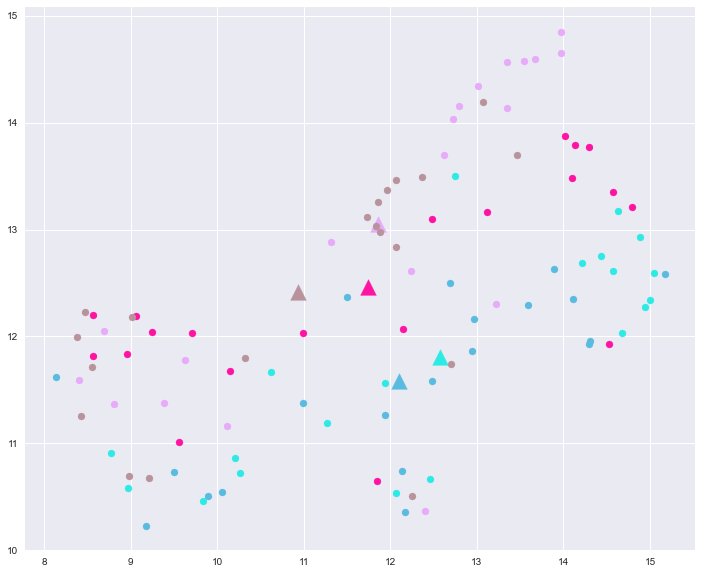

In [79]:
learn.infer(
    baseline_model,
    ls_utterances,
    ls_speakers,
    ls_dataset,
    reduction_method=reduction_method,
    figure_path=f'./results/ls-baseline-{loss_type}-{reduction_method}.png',
    device=device,
)

And now we can do the same with our pre-trained TitaNet model.

100%|████████████████████████████| 100/100 [00:09<00:00, 10.05it/s]


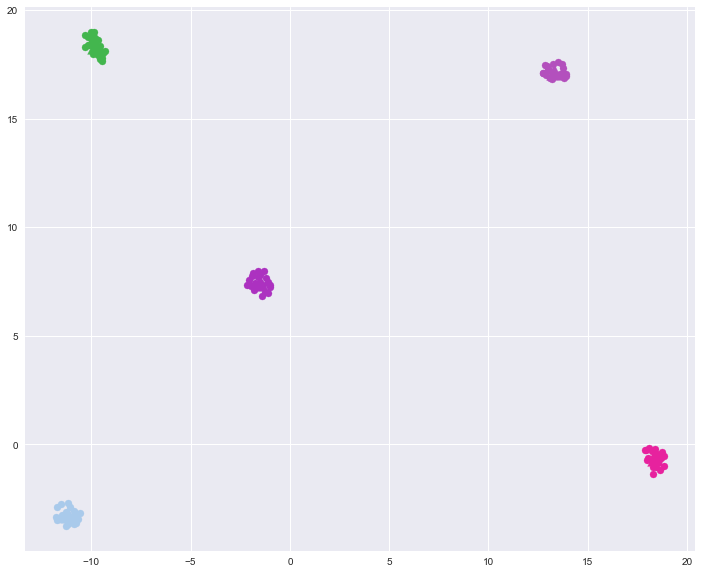

In [92]:
learn.infer(
    titanet_model,
    ls_utterances,
    ls_speakers,
    ls_dataset,
    reduction_method=reduction_method,
    figure_path=f'./results/ls-titanet-{loss_type}-{reduction_method}.png',
    device=device,
)

### VCTK dataset

Now we turn to the VCTK dataset. First of all we need to instantiate the VCTK dataset and apply resampling and mel-spectrogram transforms. Resampling is necessary so that we have the same train/inference settings, as LibriSpeech has a sample rate of $16K$, while VCTK has a sample rate of $48K$.

In [59]:
vctk_dataset = datasets.VCTKDataset(params.dataset.root, transforms=transformations)

As done with the LibriSpeech dataset, we can inspect a random example and observe its properties.

In [60]:
random_index = random.randint(0, len(vctk_dataset))
random_example = vctk_dataset[random_index]
random_example

{'waveform': tensor([[-0.0025,  0.0014,  0.0100,  ...,  0.0074,  0.0085,  0.0096]]),
 'sample_rate': 16000,
 'spectrogram': tensor([[[-0.1164, -0.0137, -0.0130,  ..., -0.0453, -0.0519, -0.0118],
          [-0.0423, -0.0207, -0.0206,  ..., -0.0475, -0.0558, -0.0111],
          [-0.0210, -0.0657, -0.0750,  ..., -0.0539, -0.0733, -0.0101],
          ...,
          [-0.2034, -0.1759, -0.1495,  ..., -0.1660, -0.1692, -0.1659],
          [-0.2035, -0.1805, -0.1603,  ..., -0.1679, -0.1736, -0.1620],
          [-0.1996, -0.1970, -0.1755,  ..., -0.1768, -0.1648, -0.1553]]]),
 'speaker': 'p330',
 'speaker_id': 88}

Now we can leverage Jupyter features to play the audio snippet directly inside this notebook.

In [61]:
utils.play_audio(random_example["waveform"], random_example["sample_rate"])

Finally, we can observe how many samples we have in the dataset and see if they are balanced for every speaker or not.

In [68]:
vctk_dataset.info()

Computing durations: 100%|███████| 43873/43873 [00:17<00:00, 2574.40it/s]


{'num_utterances': 43873,
 'num_speakers': 108,
 'total_duration': 41.04,
 'utterances_per_speaker_mean': 406.23,
 'utterances_per_speaker_std': 50.34,
 'durations_per_speaker_mean': 0.38,
 'durations_per_speaker_std': 0.06}

As done with LibriSpeech, we'll load random utterances for the given number of random speakers.

In [75]:
vctk_utterances, vctk_speakers = vctk_dataset.get_random_utterances(
    n_speakers=n_speakers, n_utterances_per_speaker=n_utterances_per_speaker
)

Then we'll compute embeddings with the baseline model.

100%|████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]


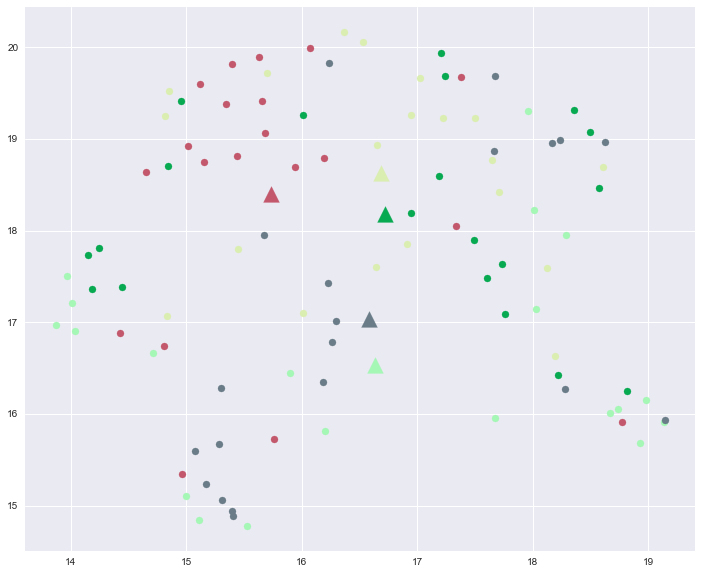

In [81]:
learn.infer(
    baseline_model,
    vctk_utterances,
    vctk_speakers,
    vctk_dataset,
    reduction_method=reduction_method,
    figure_path=f'./results/vctk-baseline-{loss_type}-{reduction_method}.png',
    device=device,
)

100%|████████████████████████████| 100/100 [00:09<00:00, 10.48it/s]


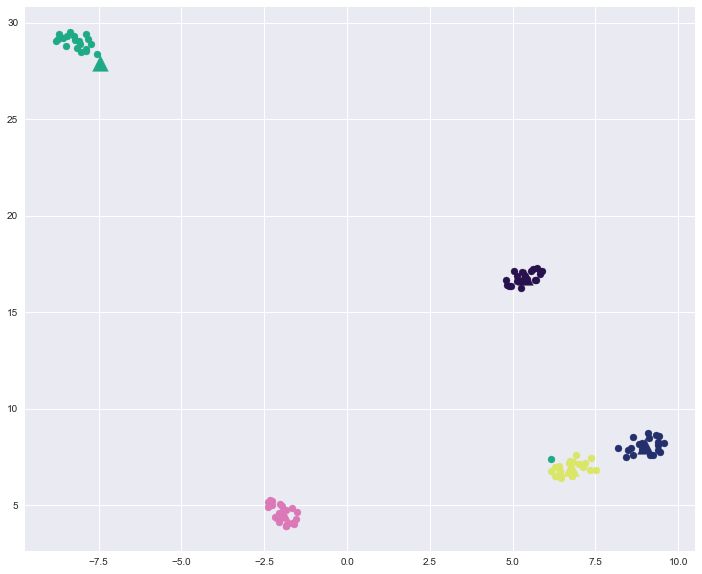

In [93]:
learn.infer(
    titanet_model,
    vctk_utterances,
    vctk_speakers,
    vctk_dataset,
    reduction_method=reduction_method,
    figure_path=f'./results/vctk-titanet-{loss_type}-{reduction_method}.png',
    device=device,
)